In [ ]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.
import torch
torch.set_float32_matmul_precision('medium') # 'medium' or 'high'. Medium is faster

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()



from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2

# Flattening Semifinals
> Which flattening method best preserves the sampling?

Here we compare five methods of neural (and non-neural) flattening, for use in constructing comparison spaces suitable for diffusion curvature.

1. Radial Flattening Autoencoder
2. Radial Flattening Autoencoder + MIOFlow
3. Geodesic Autoencoder + MIOFlow
4. PCA projections of data
5. Uniformly sampled points in $R^n$.

We evaluate these methods by their 'sampling distance' (defined in the Sampling Distance notebook) to the original space. 

These are the 'flattening semifinals' because the *ultimate* test of flattening proficiency is whether a method causes diffusion curvature to perform better than when paired with uniform random noise. *That* hypothesis remains to be evaluated.

**Hypothesis**: 

1. At least *some* methods of flattening will have a lower sampling distance than uniformly sampled data.

# Machinery

The steps here are:

1. Given a collection of manifolds of positive and negative curvature, and varying degrees of curvature, (spheres and hyperboloids), sample N neighborhoods. Add these to a dataframe together with the curvature of the originating region.
2. Run the specified flattening method (encapsulated within a function) on each of these regions.
3. Get the sampling distances between the result and the original space. Add this to another dataframe.

## Create neighborhoods dataset

In [ ]:
from diffusion_curvature.datasets import sphere, rejection_sample_from_saddle
from diffusion_curvature.sampling_distance import *
import pandas as pd
from heatgeo.embedding import HeatGeo

In [ ]:
# compute set of neighborhoods: spheres and saddles
neighbs = []
n_points_per_ds = 500
sphere_radii = [1,2,3,4,5,6,7]
saddle_intensities = [1,2,3,4,5,6,7]
# get spheres
for r in sphere_radii:
    X, ks = sphere(n = 10000, radius = r, use_guide_points=True)
    cap = X[X[:,2] > r-1]
    X_neighborhood = cap[np.concatenate([np.array([0]),np.random.choice(np.arange(1,len(cap)), size=n_points_per_ds)])]
    neighbs.append(
        {
            'X':X_neighborhood,
            'ks':ks[0],
        }
    )

In [ ]:
# get saddles
for r in saddle_intensities:
    X, ks = paraboloid(n=n_points_per_ds, a = r, b = -r,use_guide_points=True)
    neighbs.append(
        {
            'X':X,
            'ks':ks,
        }
    )

In [ ]:
# Compute manifold distances for neighbors
for N in neighbs:
    emb_op = HeatGeo(knn=5)
    emb = emb_op.fit_transform(N['X'])
    N['D'] = emb_op.dist

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


In [ ]:
# convert neighborhoods to dataframe
Neighborhoods = pd.DataFrame(neighbs)

## Baselines

In [ ]:
from diffusion_curvature.radial_flattening_ae import radially_flatten_with_ae

In [ ]:
# Comparisons
from sklearn.decomposition import PCA
def pca_projection(array):
    # Create PCA instance with 2 components
    pca = PCA(n_components=2)
    # Perform PCA on the array
    projected_array = pca.fit_transform(array)
    return projected_array

In [ ]:
def uniform_sampling_of_plane(array):
    return np.random.rand(*array.shape)

## Run Flattening
We'll define this via a function that takes the dataframe as input and returns it with a new column, containing a flattened version of each neighborhood.

In [ ]:
def semifinal_flattener(NBD, flattening_func):
    flattened_spaces = []
    for X in tqdm(NBD['X']):
        flattened_spaces.append(
            flattening_func(X)
        )
    NBD[flattening_func.__name__] = flattened_spaces
    return NBD

In [ ]:
def compute_distances(NBD):
    for flatname in tqdm(NBD.columns[3:]):
        Xs_flattened = NBD[flatname]
        sampling_dists = []
        for i in trange(len(Xs_flattened)):
            X_r = NBD['X'][i]
            X_f = Xs_flattened[i]
            D = NBD['D'][i]
            sampling_dists.append(
                sampling_distance(X_r, X_f, D)
            )
        NBD[flatname + '_dist'] = sampling_dists
    return NBD

## Visualizations

In [ ]:
def visualize_row_of_flattenings(df, i):
    row = df.iloc[i]

    bb = row['X']
    x = row['pca_projection']
    y = row['uniform_sampling_of_plane']
    z = row['radially_flatten_with_ae']
    
    labels = {
        'pca_projection': row['pca_projection_dist'],
        'uniform_sampling_of_plane': row['uniform_sampling_of_plane_dist'],
        'radially_flatten_with_ae': row['radially_flatten_with_ae_dist']
    }
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    
    
    axs[0].scatter(x[:, 0], x[:, 1], c=bb[:,0])
    axs[0].set_title('pca_projection_dist: {}'.format(labels['pca_projection']))
    axs[0].set_xlabel('Dimension 1')
    axs[0].set_ylabel('Dimension 2')
    
    axs[1].scatter(y[:, 0], y[:, 1],c=bb[:,0])
    axs[1].set_title('uniform_sampling_of_plane_dist: {}'.format(labels['uniform_sampling_of_plane']))
    axs[1].set_xlabel('Dimension 1')
    axs[1].set_ylabel('Dimension 2')
    
    axs[2].scatter(z[:, 0], z[:, 1],c=bb[:,0])
    axs[2].set_title('radially_flatten_with_ae_dist: {}'.format(labels['radially_flatten_with_ae']))
    axs[2].set_xlabel('Dimension 1')
    axs[2].set_ylabel('Dimension 2')
    
    plt.tight_layout()
    plt.show()

# Results

First we'll compute flattened neighborhoods for each of our functions of interest, 
beginning with the two baselines:

In [ ]:
Neighborhoods = semifinal_flattener(Neighborhoods, pca_projection)

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
Neighborhoods = semifinal_flattener(Neighborhoods, uniform_sampling_of_plane)

  0%|          | 0/14 [00:00<?, ?it/s]

Then our more serious models:

In [ ]:
show_doc(radially_flatten_with_ae)

---

### radially_flatten_with_ae

>      radially_flatten_with_ae (X, D=None, learning_rate=1e-05,
>                                intrinsic_dim=2, return_model=False)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| X |  |  |  |
| D | NoneType | None | if not supplied, computes with heatgeo |
| learning_rate | float | 1e-05 |  |
| intrinsic_dim | int | 2 |  |
| return_model | bool | False |  |

In [ ]:
Neighborhoods = semifinal_flattener(Neighborhoods, radially_flatten_with_ae)

  0%|          | 0/14 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using s_gd2 for MDS. None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
Neighborhoods = compute_distances(Neighborhoods)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
Neighborhoods

,X,ks,D,pca_projection,uniform_sampling_of_plane,radially_flatten_with_ae,pca_projection_dist,uniform_sampling_of_plane_dist,radially_flatten_with_ae_dist
0,"[[0.0, 0.0, 1.0], [-0.4357196977943364, -0.012...",2.0,"[[10.145038037854674, 14.735097854590206, 12.2...","[[0.014115594077049983, 0.008249747911001463],...","[[0.5974601659662989, 0.3420858316723372, 0.28...","[[0.08103236, 0.28086704], [-0.025159039, 0.29...",10.842406,10.983668,11.064636
1,"[[1.5582933067217914, 0.6667589106028755, 1.06...",0.5,"[[10.96838517092394, 32.09508908168607, 27.043...","[[0.24621480306638882, 1.677197052196671], [-0...","[[0.28202503225973086, 0.5095050004465025, 0.7...","[[-0.16019306, -0.47463942], [-0.6381352, -0.7...",10.792425,11.027989,12.036566
2,"[[-0.7295865437179441, 0.23429401983089185, 2....",0.222222,"[[11.06971762616811, 33.547983215938345, 19.88...","[[0.6566494874146258, 0.43552159245435085], [-...","[[0.8083614265346726, 0.9797215087047891, 0.15...","[[-1.539547, -0.35915017], [-0.9157379, -0.464...",10.536917,10.940026,11.147720
3,"[[-1.6255374776041094, -1.976190005687658, 3.0...",0.125,"[[9.949626803032128, 16.610970964987327, 19.03...","[[-0.48448060988606384, 2.518029410040194], [-...","[[0.31775289601888135, 0.24321833466038778, 0....","[[-1.1187598, -1.1502208], [-0.99930507, -0.94...",10.748173,11.157134,11.979811
4,"[[-0.3479236979626259, -2.7443356856690393, 4....",0.08,"[[10.221619601170312, 15.627569795891903, 35.1...","[[2.0462942874461962, 1.8024272950425344], [0....","[[0.8926738296799622, 0.5808494438505504, 0.64...","[[1.1358327, 1.3495592], [1.0984888, 1.200377]...",10.637154,10.889432,11.476040
5,"[[-0.41802459541076387, -2.8974644018818263, 5...",0.055556,"[[11.381787647778982, 36.31199874433781, 38.27...","[[-0.9096682618097458, -2.5599612264835847], [...","[[0.7167318925695347, 0.4647484153672522, 0.67...","[[-0.71350354, -2.7071414], [-1.0286778, -2.36...",10.552368,10.971983,11.545441
6,"[[-0.6343120593800367, 3.3004578904970225, 6.1...",0.040816,"[[10.706171034770328, 37.8010628687023, 34.993...","[[0.6348649325783842, -3.1787500398571042], [2...","[[0.34889570937177117, 0.6192951972845374, 0.6...","[[5.8660755, -6.8217416], [5.430492, -6.84456]...",10.496143,11.311120,11.476301
7,"[[0.0, 0.0, 0.0], [0.5035672480457889, -0.4531...","[-4.0, -0.49743046756656434, -0.16419790659282...","[[11.030905685197997, 27.278133668653705, 22.4...","[[-0.000965361089813933, 0.008627615979734733]...","[[0.5226084678469066, 0.876063807267788, 0.384...","[[0.045090884, 0.11920338], [0.094252944, -0.2...",10.842758,11.107219,11.244847
8,"[[0.0, 0.0, 0.0], [-0.6450688443714567, -0.592...","[-0.25, -0.17604776272476477, -0.1750154388756...","[[10.47910506441425, 21.799374809335227, 27.80...","[[0.06863801759389722, 0.012417920308095543], ...","[[0.6621670229961305, 0.5466168209804324, 0.40...","[[-0.29921594, 0.15678287], [-0.1139793, 0.250...",10.917446,11.408505,10.887669
9,"[[0.0, 0.0, 0.0], [-0.5155796802064356, 0.2267...","[-0.04938271604938271, -0.04787105651509146, -...","[[11.279873764979595, 15.78162591329183, 19.05...","[[0.022019320976120423, 0.01897225831052527], ...","[[0.8895706334327357, 0.04384364151147835, 0.6...","[[0.19158249, 0.21608527], [0.26492763, -0.036...",10.930172,11.541422,10.988114


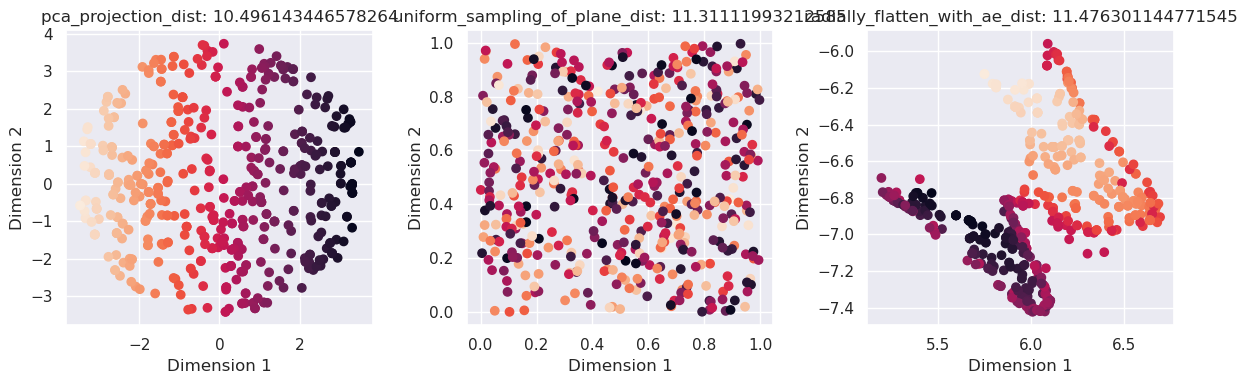

In [ ]:
visualize_row_of_flattenings(Neighborhoods,6)

# Conclusion